# Show and Tell

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms  # transform PIL images into tensors
import torchvision.models as models  # train or load pre-trained models
from torchvision import datasets

import torch.utils.data as data
from torch.autograd import Variable as var

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
imsize = 224

preprocess = transforms.Compose([
  transforms.Resize(imsize),
  transforms.CenterCrop(imsize),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

#https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

##Download Flickr8k dataset

In [4]:
import os
import urllib
import zipfile

if os.path.isdir("./Flicker8k_Dataset"):
  print("Dataset is already downloaded")
else:
  urllib.request.urlretrieve("https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip", "Flickr8k_image.zip")
  Flickr8k_image = zipfile.ZipFile('./Flickr8k_image.zip')
  Flickr8k_image.extractall('.')
  Flickr8k_image.close()
  urllib.request.urlretrieve("https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip", "Flickr8k_caption.zip")
  Flickr8k_text = zipfile.ZipFile('./Flickr8k_caption.zip')
  Flickr8k_text.extractall('.')
  Flickr8k_text.close()
  print("Flickr8k dataset is downloaded")


Flickr8k dataset is downloaded


In [5]:
import re

class flickr8k():
  def __init__(self, img_folder_path = "./Flicker8k_Dataset"
                   , caption_path = "./Flickr8k.token.txt"
                   , rank = 4):
    """ Initializer
        param img_folder_path: image folder path
        param caption_path: caption text file path
        param rank: caption rank setting

        param captionMap: hash map (key: image_id, value: caption)
        param trainingSet: 
        param validationSet: 
        param testSet:
    """
    self.img_folder_path = img_folder_path
    self.caption_path = caption_path
    self.rank = rank
    self.captionMap = self.readCaptions()
    self.trainingSet = self.loadDataset("./Flickr_8k.trainImages.txt")
    self.validationSet = self.loadDataset("./Flickr_8k.devImages.txt")
    self.testSet = self.loadDataset("./Flickr_8k.testImages.txt")

  def readCaptions(self):
    # read caption text file and return captionMap (key: image_id, value: caption)
    captionMap = {}
    f = open(self.caption_path, "r")
    fR = f.readlines()
    #match_re = r'(.*).jpg#' + str(self.rank) + '\s+(.*)'
    match_re = r'(.*).jpg#[0-9]\s+(.*)'
    for line in fR:
      match = re.match(match_re, line)
      if match:
        image_id = match.group(1)
        image_caption = match.group(2)
        if image_id not in captionMap:
          captionMap[image_id] = []
        captionMap[image_id].append(image_caption)

    return captionMap

  def loadImage(self, image_id):
    # return image path 
    image_path = os.path.join(self.img_folder_path, image_id + ".jpg")
    return image_path
    
  def loadDataset(self, dataPath):
    # based on dataset path, extract training set, validation set, or test set
    # return a list of object contains image id and caption
    dataset = []
    f = open(dataPath, "r")
    fR = f.readlines()
    match_re = r'(.*).jpg'
    for line in fR:
      match = re.match(match_re, line)
      if match:
        image_id = match.group(1)
        for c in self.captionMap[image_id]:
          dataset.append({"image_id": image_id, "caption": c})
        
    return dataset

f = flickr8k("./Flicker8k_Dataset", "./Flickr8k.token.txt")
list(f.captionMap.keys())[0]
print(f.trainingSet[0])
print(f.trainingSet[1])
#f.testSet[0]
#f.loadImage("1305564994_00513f9a5b")

{'image_id': '2513260012_03d33305cf', 'caption': 'A black dog is running after a white dog in the snow .'}
{'image_id': '2513260012_03d33305cf', 'caption': 'Black dog chasing brown dog through snow'}


##Build Vocabulary

In [6]:
from collections import Counter
import nltk
nltk.download('punkt')

class Vocabulary():
  def __init__(self):
    
    self.wordId = 0
    self.wordToId = {}
    self.idToWord = {}

  def add_word(self, word):

    if not word in self.wordToId:
      self.wordToId[word] = self.wordId
      self.idToWord[self.wordId] = word
      self.wordId += 1
  
  def getId(self, word):
    
    if not word in self.wordToId:
      return self.wordToId["<unk>"]
    return self.wordToId[word]

  def getWord(self, Id):
    return self.idToWord[Id]

  def vocabSize(self):

    return len(self.wordToId)

def buildVocab(captionPath, threshold):

  flickr = flickr8k(caption_path = captionPath)
  # count the number of every word
  counter = Counter()
  for id in flickr.captionMap:
    captions = flickr.captionMap[id]
    for c in captions:
      tokens = nltk.tokenize.word_tokenize(c.lower())
      counter.update(tokens)
    
  # filter out words by threshold
  words = []
  for word, count in counter.items():
    if count >= threshold:
      words.append(word)
  
  # add words in vocabulary
  vocab = Vocabulary()
  vocab.add_word('<start>')
  vocab.add_word('<end>')
  vocab.add_word('<unk>')

  for word in words:
    vocab.add_word(word)
  
  return vocab

def idToSentence(id, v):
    from itertools import takewhile as tw
    
    wordlist = [v.wordToId[w] for w in ['<start>']]
    predicate = lambda w_id: v.idToWord[w_id] != '<end>'
    output = [v.idToWord[w_id] for w_id in tw(predicate, id) if w_id not in wordlist]

    sentence = ' '.join(output)
    return sentence

vocabulary = buildVocab("./Flickr8k.token.txt", 1)
vocabulary.vocabSize()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


8920

In [0]:
class DataLoader(data.Dataset):
  def __init__(self, imageFolder, tokenPath, rank, vocab, stage, transform=None):
    """ Initializer
        param imageFolder: image folder path
        param tokenPath: caption text file path
        param rank: caption rank setting
        param vocab: vocabulary
        param stage: "train", "validation", "test" 
        param transform: 
    """
    self.root = imageFolder
    self.flickr = flickr8k(img_folder_path = imageFolder, caption_path = tokenPath, rank = rank)
    self.vocab = vocab
    self.stage = stage
    self.transform = transform
    if stage == 'train':
      self.dataset = self.flickr.trainingSet
    elif stage == 'validation':
      self.dataset = self.flickr.validationSet
    elif stage == 'test':
      self.dataset = self.flickr.testSet
    else:
      self.dataset = self.flickr.trainingSet

  def __getitem__(self, index):

    flickr = self.flickr
    vocab = self.vocab
    
    caption = self.dataset[index]['caption']
    img_id = self.dataset[index]['image_id']
    path = flickr.loadImage(img_id)

    image = Image.open(path).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
    
    # tokenize caption
    tok  = nltk.tokenize.word_tokenize(str(caption).lower())
    caption = []
    caption.append(vocab.getId('<start>'))
    caption.extend([vocab.getId(token) for token in tok])
    caption.append(vocab.getId('<end>'))
    target = torch.Tensor(caption)

    return image, target

  def __len__(self):

    return len(self.dataset)

In [0]:
def collate_fn(data):
  
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)

  images = torch.stack(images, 0)  

  lengths = []
  for cap in captions:
    lengths.append(len(cap))
  
  targets = torch.zeros(len(captions), max(lengths)).long()

  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]
  
  return images, targets, lengths

In [0]:
def get_dataloader(imageFolder, tokenPath, rank, vocab, stage, transform, batch_size, shuffle,
               num_workers):
  
  flickr = DataLoader(
      imageFolder, tokenPath, rank, vocab, stage, transform)

  data_loader = torch.utils.data.DataLoader(
      dataset=flickr,
      batch_size=batch_size,
      shuffle=shuffle,
      num_workers=num_workers,
      collate_fn=collate_fn)
  
  return data_loader

In [0]:
# Hyperparameters for model-building
max_epochs = 1
test_epochs = 50
save_epochs = 100
learning_rate = 0.001
batch_size = 4
num_workers = 2
embed_size = 1000
hidden_size = 1000

##Load dataset 

In [0]:
train_loader = get_dataloader(
    imageFolder = "./Flicker8k_Dataset", 
    tokenPath = "./Flickr8k.token.txt", 
    rank = 4, 
    vocab = vocabulary,  
    stage = "train", 
    transform = preprocess, 
    batch_size = batch_size,
    shuffle=True,
    num_workers = num_workers)

val_loader = get_dataloader(
    imageFolder = "./Flicker8k_Dataset", 
    tokenPath = "./Flickr8k.token.txt", 
    rank = 4, 
    vocab = vocabulary,  
    stage = "validation", 
    transform = preprocess, 
    batch_size = batch_size,
    shuffle=True,
    num_workers = num_workers)

##CNN model & RNN model

In [0]:
class GoogleNet(nn.Module): 
    def __init__(self, output_dim=1000):
        super(GoogleNet, self).__init__()
        pretrained_model = models.googlenet(pretrained=True) # Get pre-trained googlenet from torchvision
        self.googlenet = nn.Sequential(*list(pretrained_model.children())[:-1]) # Remove the output layer in the googlenet
        self.linear = nn.Linear(pretrained_model.fc.in_features, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim, momentum=0.01)
        self.init_weights()

    def init_weights(self): # weight init, inspired by tutorial
        self.linear.weight.data.normal_(0,0.02)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        x = self.googlenet(x)
        x = var(x.data)
        x = x.view(x.size(0), -1) # flatten
        x = self.linear(x)

        return x


class CaptionGeneratingModel(torch.nn.Module): #LSTM Caption Generating Model
    def __init__(self, emb_size, hidden_size, vocab_size, num_layers=1):
        # emb_size: size of word embeddings, hidden_size: size of hidden state
        # vocab_size: size of the vocabulary, num_layers: number of layers

        super(CaptionGeneratingModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.unit = nn.LSTM(emb_size, hidden_size, num_layers,
                                                 batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        # features: feature parameters from GoogleNet
        # captions: encoded and padded (target) image captions
        # length: actual length of image captions

        embeddings = self.embeddings(captions) # Embed tokens in vector space

        inputs = torch.cat((features.unsqueeze(1), embeddings), 1) # Append image as first input

        inputs_packed = pack_padded_sequence(inputs, lengths, batch_first=True) # Pack data

        hiddens, _ = self.unit(inputs_packed) # Run data through recurrent network
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, max_len=25):
        # features: features for GoogleNet 
        
        output_ids = []
        states = None
        inputs = features.unsqueeze(1)

        for i in range(max_len):
            hiddens, states = self.unit(inputs, states) # Pass data through recurrent network
            outputs = self.linear(hiddens.squeeze(1))

            predicted = outputs.max(1)[1] # Find maximal predictions

            output_ids.append(predicted) # Append results from given step to global results

            inputs = self.embeddings(predicted) # Prepare chosen words for next decoding step
            inputs = inputs.unsqueeze(1)
        output_ids = torch.stack(output_ids, 1)
        return output_ids.squeeze() # Return predicted image captions

## Loss Function

In [0]:
# Loss function (Negative Log-likelihood Loss with Softmax)
# Equivalently, Cross-Entropy Loss
loss_function = nn.CrossEntropyLoss()

## Train the Model
We save our checkpoint file in '/gdrive/My Drive/my_data/checkpoints'

In [14]:
# Initialize the model
googleNet = GoogleNet(embed_size)
captionModel = CaptionGeneratingModel(embed_size, hidden_size, vocabulary.vocabSize())
googleNet.to(device)
captionModel.to(device)

params = list(captionModel.parameters())
params += list(googleNet.linear.parameters())
params += list(googleNet.batchnorm.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate)

train_loss = [0.0]
val_loss = [0.0]
loader_length = len(train_loader)
start_index = 0
start_batch = 0
base_dir = os.path.join(gdrive_data, 'checkpoints')
checkpoint_name = None
# checkpoint_name = '1_300.pt'

# Load checkpoint
if isinstance(checkpoint_name, str):
  try:
    checkpoint_file = os.path.join(base_dir, checkpoint_name)
    checkpoint = torch.load(checkpoint_file)
    CNN_state_dict = checkpoint['CNN']
    RNN_state_dict = checkpoint['RNN']
    googleNet.load_state_dict(CNN_state_dict)
    captionModel.load_state_dict(RNN_state_dict)
    optimizer = checkpoint['optimizer']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    start_index = checkpoint['epoch']
    start_batch = checkpoint['batch_number']

    if start_batch == loader_length - 1:
      start_batch = 0
      start_index += 1
    
    embed_size = checkpoint['embed_size']
    hidden_size = checkpoint['hidden_size']
    print('Checkpoint loaded')
  except:
    print('Checkpoint load failed')

# Train the model
for i in range(start_index, max_epochs):
  for j, (features, captions, lengths) in enumerate(train_loader):

    if start_batch != 0 and j <= start_batch:
      continue

    # Initalize and optimize
    googleNet.zero_grad()
    captionModel.zero_grad()

    # Convert into tensors for inputs and ground-truth outputs
    features = var(features, volatile = True).to(device)
    captions = var(captions, volatile = False).to(device)
    groundtruth_outputs = pack_padded_sequence(captions, 
                                               lengths, 
                                               batch_first = True)[0]

    # Training steps with back-propagation
    intermediates = googleNet(features)
    outputs = captionModel(intermediates, 
                           captions, 
                           lengths)
    loss = loss_function(outputs, groundtruth_outputs)
    train_loss.append(loss.data.item())
    loss.backward()
    optimizer.step()

    # Check validation and test the current state
    if (j + 1) % test_epochs == 0:

      # Change batch normalization state
      googleNet.batchnorm.eval()
      
      # Check validation of the model
      import random
      index = random.randrange(0, len(val_loader))
      for k, (features, captions, lengths) in enumerate(val_loader):

          if k == index:
            # Convert into tensors for inputs and ground-truth outputs
            features = var(features, volatile=True).to(device)
            captions = var(captions, volatile=True).to(device)
            groundtruth_outputs = pack_padded_sequence(captions, 
                                                      lengths, 
                                                      batch_first=True)[0]
            
            # Check validation with foward-propagation
            intermediates = googleNet(features)
            outputs = captionModel(intermediates, 
                                  captions, 
                                  lengths)
            loss = loss_function(outputs, groundtruth_outputs)
            val_loss.append(loss.data.item())

            # Test the current state
            evaluation = captionModel.sample(intermediates)
            evaluation = evaluation.cpu().data.numpy()[0]
            sentence = idToSentence(evaluation, vocabulary)
            print('Evaluation  :', sentence)

            groundtruth = captions.cpu().data.numpy()[0]
            sentence = idToSentence(groundtruth, vocabulary)
            print('Ground-truth:', sentence)
            print('Eval Loss   : {:.4f}'.format(val_loss[-1]))
            print('Epoch: {}, Batch: {}, Train Loss: {:.4f}'.format(i, j, train_loss[-1]))

            break

      # Change batch normalization state
      googleNet.batchnorm.train()
    
    else:
      print('Epoch: {}, Batch: {}, Train Loss: {:.4f}'.format(i, j, train_loss[-1]))

    # Save checkpoint
    if (j + 1) % save_epochs == 0:
      if not os.path.exists(base_dir):
        os.makedirs(base_dir)
      checkpoint_file = os.path.join(base_dir, '%d_%d.pt' % (i + 1, j + 1))
      torch.save({'CNN': googleNet.state_dict(), 'RNN': captionModel.state_dict(), 'optimizer': optimizer, 'train_loss': train_loss, 'val_loss': val_loss, 'epoch': i, 'batch_number': j, 'embed_size' : embed_size, 'hidden_size' : hidden_size}, checkpoint_file)  
      print('Checkpoint saved')

  start_batch = 0


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 99.2MB/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 0, Batch: 0, Train Loss: 9.1132
Epoch: 0, Batch: 1, Train Loss: 8.8576
Epoch: 0, Batch: 2, Train Loss: 8.5240
Epoch: 0, Batch: 3, Train Loss: 8.0832
Epoch: 0, Batch: 4, Train Loss: 7.8059
Epoch: 0, Batch: 5, Train Loss: 6.4703
Epoch: 0, Batch: 6, Train Loss: 5.4046
Epoch: 0, Batch: 7, Train Loss: 5.4500
Epoch: 0, Batch: 8, Train Loss: 6.0394
Epoch: 0, Batch: 9, Train Loss: 5.0829
Epoch: 0, Batch: 10, Train Loss: 5.8666
Epoch: 0, Batch: 11, Train Loss: 5.9186
Epoch: 0, Batch: 12, Train Loss: 4.7348
Epoch: 0, Batch: 13, Train Loss: 5.0485
Epoch: 0, Batch: 14, Train Loss: 4.8238
Epoch: 0, Batch: 15, Train Loss: 4.7271
Epoch: 0, Batch: 16, Train Loss: 4.8400
Epoch: 0, Batch: 17, Train Loss: 4.9679
Epoch: 0, Batch: 18, Train Loss: 4.1146
Epoch: 0, Batch: 19, Train Loss: 4.6800
Epoch: 0, Batch: 20, Train Loss: 4.2769
Epoch: 0, Batch: 21, Train Loss: 5.0670
Epoch: 0, Batch: 22, Train Loss: 5.2839
Epoch: 0, Batch: 23, Train Loss: 4.1962
Epoch: 0, Batch: 24, Train Loss: 4.9121
Epoch: 0, 

KeyboardInterrupt: ignored

## Random Inference from Flickr test dataset

<start> a man in a blue shirt is standing in a field of snow . <end>


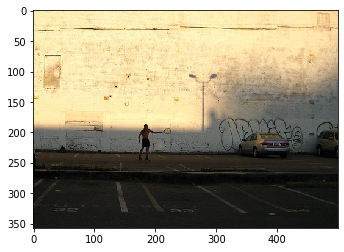

In [15]:
import random
import numpy as np

def getRandomImage(img_list):
  """
  Returns a random filename, chosen among the files of the given path.
  """
  index = random.randrange(0, len(img_list))
  return img_list[index]

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224])
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

#Loading checkpoint and initializing encoder and decoder
ckpt_dir = os.path.join(gdrive_data, 'checkpoints')
ckpt_path = os.path.join(ckpt_dir, '60_1835.pt')
checkpoint = torch.load(ckpt_path)
embed_size = checkpoint['embed_size']
hidden_size = checkpoint['hidden_size']

encoder = GoogleNet(embed_size).to(device)
decoder = CaptionGeneratingModel(embed_size, hidden_size, vocabulary.vocabSize(),1).to(device)

decoder_state_dict = checkpoint['RNN']
encoder_state_dict = checkpoint['CNN']
encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

encoder.eval()
decoder.eval()

#Acquiring list of images
img_list=[]
with open('./Flickr_8k.testImages.txt','r') as f:
  for i in f:
    img_list.append(i.strip())

#Choosing a random image for evaluation
filename = getRandomImage(img_list)
image = load_image('./Flicker8k_Dataset/'+ str(filename), preprocess)
image = image.to(device)
features = encoder(image)
caps = decoder.sample(features)
caps = caps.cpu().data.numpy()
caption = []

#Changing word indexes into words
for word_id in caps:
    word = vocabulary.getWord(word_id.item())
    caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(caption)

#Printing caption and showing the image
print (sentence)
image = Image.open('./Flicker8k_Dataset/'+ str(filename))
plt.imshow(np.asarray(image))

## BLEU-1 Metric Score

In [16]:
from nltk.translate.bleu_score import corpus_bleu

def bleu(val_loader, encoder, decoder):
    """
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :return: BLEU-1 score
    """

    encoder.eval()
    decoder.eval()
    
    references = list()  # Labeled sentences
    hypotheses = list()  # Predicted sentences
 
    for i, (imgs, caps, caplens) in enumerate(val_loader):

        imgs = imgs.to(device)
        caps = caps.to(device)

        feature = encoder(imgs)
        sampled_ids = decoder.sample(feature)

        #Hypotheses
        for i in range(sampled_ids.shape[0]):
          sampled = sampled_ids[i].cpu().numpy()
          caption = []
          for word_id in sampled:
            if word_id == vocabulary.getId('<end>'):
                break
            caption.append(word_id)
          if(caption[0]== 0):
              caption.remove(0)
          hypotheses.append(caption)

        # References
        for j in range(caps.shape[0]):
            img_caps = caps[j].tolist()
            img_captions = list(
                map(
                    lambda c: [
                        w for w in img_caps if w not in
                        {vocabulary.getId('<start>'),
                         vocabulary.getId('<end>')}
                    ], img_caps))  # First and last unnecessary tokens removed
            references.append(img_captions)

    assert len(references) == len(hypotheses)
 
    #Bleu
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0/1.0,))
    #bleu4 = corpus_bleu(references, hypotheses, weights=(1.0/4.0, 1.0/4.0, 1.0/4.0, 1.0/4.0,))

    print('BLEU-1: {bleu}\n'.format(bleu=bleu1))
    #print('BLEU-4: {bleu}\n'.format(bleu=bleu4))

    return bleu1

#Loading checkpoint and initializing encoder and decoder
ckpt_dir = os.path.join(gdrive_data, 'checkpoints')
ckpt_path = os.path.join(ckpt_dir, '60_1835.pt')
checkpoint = torch.load(ckpt_path)

embed_size = checkpoint['embed_size']
hidden_size = checkpoint['hidden_size']

encoder = GoogleNet(embed_size).to(device)
decoder = CaptionGeneratingModel(embed_size, hidden_size, vocabulary.vocabSize(),1).to(device)

decoder_state_dict = checkpoint['RNN']
encoder_state_dict = checkpoint['CNN']
encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

#Execution of bleu 
bleu(val_loader, encoder, decoder)  

BLEU-1: 0.2946672813892732



0.2946672813892732